## Tweets disater


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import missingno as msno
import re

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam

from keras.utils import np_utils

import warnings 
warnings.filterwarnings(action='ignore')

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/nlp_tweets_disaster/train_disaster.csv',encoding='utf-8')
test = pd.read_csv('/content/drive/MyDrive/nlp_tweets_disaster/test_disaster.csv',encoding='utf-8')
sample_submission = pd.read_csv('/content/drive/MyDrive/nlp_tweets_disaster/sample_submission_disaster.csv',encoding='utf-8')

In [ ]:
train.describe()

AttributeError: ignored

### 전처리

In [ ]:
#location column은 삭제
train.drop(columns = 'location', inplace = True)
test.drop(columns = 'location', inplace = True)

### 결측치 확인

In [ ]:
#msno matrix
msno.matrix(train)
plt.show()

In [ ]:
#결측치 확인(keyword)
train['keyword'].isnull().sum(), test['keyword'].isnull().sum()

### Text 전처리/url, tag, 불용어 제거

In [ ]:
from nltk.corpus import stopwords
import nltk

In [ ]:
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#url 주소 tweets 제거
def url_remove(text):
  tag = re.compile('[http]\S*')
  return re.sub(tag,'',text)

#@로 시작되는 tag 제거
def tag_remove(text):
  tag = re.compile('[@]\w*')
  return re.sub(tag,'',text)

#불용어 제거
def remove_stopwords(text):
    removed_text = []
    for i in text.split():
        if i.strip().lower() not in eng_stopwords:
            removed_text.append(i.strip())
    return " ".join(removed_text)

#특수기호 제거
def alpha_num(text):
    return re.sub(r'[^a-zA-Z0-9 ]', '', text)

In [ ]:
#전처리 적용
train['text'] = train['text'].str.lower()
test['text'] = test['text'].str.lower()
train['text'] = train['text'].apply(url_remove).apply(tag_remove).apply(remove_stopwords).apply(alpha_num)
test['text'] = test['text'].apply(url_remove).apply(tag_remove).apply(remove_stopwords).apply(alpha_num)

### 데이터 분포 확인

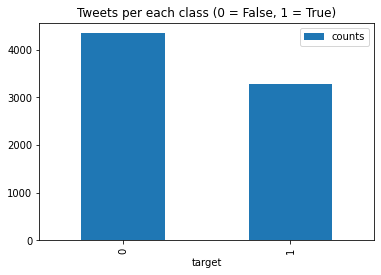

In [ ]:
#진성, 가성 tweets 분포 확인
train.groupby(train.target).size().reset_index(name="counts").plot.bar(x='target',title="Tweets per each class (0 = False, 1 = True)")

In [ ]:
# 문장 길이 분포도 확인(불용어 제외 단어수)
df = pd.concat([train, test], axis = 0)
df['doc_len'] = df.text.apply(lambda words: len(words.split()))

In [ ]:
# 99% 기준으로 추후 데이터 학습에 사용하려 했으나, max 값이 별로 크지 않아 max 값 사용
percent =[0.25,0.5,0.75,0.99]
df['doc_len'].describe(percentiles = percent)


count    10876.000000
mean         7.598014
std          3.369894
min          0.000000
25%          5.000000
50%          7.000000
75%         10.000000
99%         16.000000
max         22.000000
Name: doc_len, dtype: float64

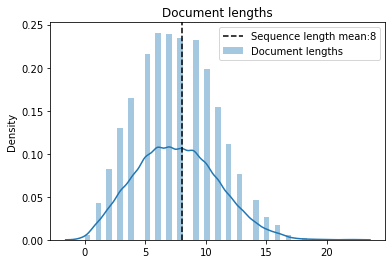

 가장 긴 문장은 22 개의 단어를, 가장 짧은 문장은 0 개의 단어를 가지고 있습니다.


In [ ]:
def plot_doc_lengths(dataframe):
    mean_seq_len = np.round(dataframe.doc_len.mean()).astype(int)
    sns.distplot(tuple(dataframe.doc_len), hist=True, kde=True, label='Document lengths')
    plt.axvline(x=mean_seq_len, color='k', linestyle='--', label=f'Sequence length mean:{mean_seq_len}')
    plt.title('Document lengths')
    plt.legend()
    plt.show()
    print(f" 가장 긴 문장은 {df['doc_len'].max()} 개의 단어를, 가장 짧은 문장은 {df['doc_len'].min()} 개의 단어를 가지고 있습니다.")

plot_doc_lengths(df)

### Token화 및 정수 encoding

In [ ]:
def tokenizer(doc):
    result = []
    tknzr = TreebankWordTokenizer()
    tks = tknzr.tokenize(doc)
    for tk in tks:
        result.append(tk)
    return result

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import TreebankWordTokenizer

#Token화
df = pd.concat([train, test], axis = 0)
df["tokenized_text"]=df['text'].apply(tokenizer)
df

,id,keyword,text,target,tokenized_text
0,1,NaN,deeds reason ear may alla forgive us,1.0,"[deeds, reason, ear, may, alla, forgive, us]"
1,4,NaN,fores fire near la ronge sask canada,1.0,"[fores, fire, near, la, ronge, sask, canada]"
2,5,NaN,residen asked s officers evacua orders ex,1.0,"[residen, asked, s, officers, evacua, orders, ex]"
3,6,NaN,13000 receive wildfires evacua orders california,1.0,"[13000, receive, wildfires, evacua, orders, ca..."
4,7,NaN,jus go sen ruby alaska smoke wildfires sc,1.0,"[jus, go, sen, ruby, alaska, smoke, wildfires,..."
...,...,...,...,...,...
3258,10861,NaN,ear safe los angeles safe fas xrwn,NaN,"[ear, safe, los, angeles, safe, fas, xrwn]"
3259,10865,NaN,ri worse las ci yard looks like bombed around ...,NaN,"[ri, worse, las, ci, yard, looks, like, bombed..."
3260,10868,NaN,green line derailmen c,NaN,"[green, line, derailmen, c]"
3261,10874,NaN,meg issues wea ou,NaN,"[meg, issues, wea, ou]"


In [ ]:
#token 정수 encoding
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tokenized_text'])
df['encoded_text'] = tokenizer.texts_to_sequences(df['tokenized_text'])
df

,id,keyword,text,target,tokenized_text,encoded_text
0,1,NaN,deeds reason ear may alla forgive us,1.0,"[deeds, reason, ear, may, alla, forgive, us]","[3491, 574, 105, 58, 1152, 2385, 27]"
1,4,NaN,fores fire near la ronge sask canada,1.0,"[fores, fire, near, la, ronge, sask, canada]","[106, 14, 160, 42, 4934, 4935, 980]"
2,5,NaN,residen asked s officers evacua orders ex,1.0,"[residen, asked, s, officers, evacua, orders, ex]","[728, 1044, 47, 1231, 43, 1153, 13]"
3,6,NaN,13000 receive wildfires evacua orders california,1.0,"[13000, receive, wildfires, evacua, orders, ca...","[2071, 2793, 884, 43, 1153, 55]"
4,7,NaN,jus go sen ruby alaska smoke wildfires sc,1.0,"[jus, go, sen, ruby, alaska, smoke, wildfires,...","[8, 15, 708, 3492, 1828, 209, 884, 84]"
...,...,...,...,...,...,...
3258,10861,NaN,ear safe los angeles safe fas xrwn,NaN,"[ear, safe, los, angeles, safe, fas, xrwn]","[105, 419, 482, 1834, 419, 199, 10799]"
3259,10865,NaN,ri worse las ci yard looks like bombed around ...,NaN,"[ri, worse, las, ci, yard, looks, like, bombed...","[541, 847, 73, 91, 2187, 219, 7, 380, 243, 374..."
3260,10868,NaN,green line derailmen c,NaN,"[green, line, derailmen, c]","[583, 392, 320, 2]"
3261,10874,NaN,meg issues wea ou,NaN,"[meg, issues, wea, ou]","[2715, 425, 38, 5]"


In [ ]:
#padding, 가장 긴 문장의 길이가 22이 이므로 22로 padding
from tensorflow.keras.preprocessing.sequence import pad_sequences

df['padded'] = df['encoded_text'].apply(lambda x: pad_sequences([x], padding='pre', maxlen=22))
df

,id,keyword,text,target,tokenized_text,encoded_text,padded
0,1,NaN,deeds reason ear may alla forgive us,1.0,"[deeds, reason, ear, may, alla, forgive, us]","[3491, 574, 105, 58, 1152, 2385, 27]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,4,NaN,fores fire near la ronge sask canada,1.0,"[fores, fire, near, la, ronge, sask, canada]","[106, 14, 160, 42, 4934, 4935, 980]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,5,NaN,residen asked s officers evacua orders ex,1.0,"[residen, asked, s, officers, evacua, orders, ex]","[728, 1044, 47, 1231, 43, 1153, 13]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,6,NaN,13000 receive wildfires evacua orders california,1.0,"[13000, receive, wildfires, evacua, orders, ca...","[2071, 2793, 884, 43, 1153, 55]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,7,NaN,jus go sen ruby alaska smoke wildfires sc,1.0,"[jus, go, sen, ruby, alaska, smoke, wildfires,...","[8, 15, 708, 3492, 1828, 209, 884, 84]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8,..."
...,...,...,...,...,...,...,...
3258,10861,NaN,ear safe los angeles safe fas xrwn,NaN,"[ear, safe, los, angeles, safe, fas, xrwn]","[105, 419, 482, 1834, 419, 199, 10799]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3259,10865,NaN,ri worse las ci yard looks like bombed around ...,NaN,"[ri, worse, las, ci, yard, looks, like, bombed...","[541, 847, 73, 91, 2187, 219, 7, 380, 243, 374...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 541, 847, 7..."
3260,10868,NaN,green line derailmen c,NaN,"[green, line, derailmen, c]","[583, 392, 320, 2]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3261,10874,NaN,meg issues wea ou,NaN,"[meg, issues, wea, ou]","[2715, 425, 38, 5]","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [ ]:
#훈련용 데이터 생성/keras dataset api 사용
from sklearn.model_selection import train_test_split

train_x = np.stack(df.iloc[:len(train), -1]).astype('float32')
train_y = df.iloc[:len(train), 3]

train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.15, 
                                                  shuffle=True, random_state=0)

test_x = np.stack(df.iloc[len(train):, -1]).astype('float32')
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y)).shuffle(10000).batch(128).prefetch(1000)
val_ds = tf.data.Dataset.from_tensor_slices((val_x, val_y)).batch(128).prefetch(1000)

In [ ]:
train_y

5378    0.0
731     0.0
1282    0.0
3769    1.0
7513    1.0
       ... 
4931    0.0
3264    1.0
1653    1.0
2607    0.0
2732    0.0
Name: target, Length: 6471, dtype: float64

Epoch 1/1000
51/51 [==============================] - 3s 15ms/step - loss: 0.7028 - accuracy: 0.5318 - val_loss: 0.6844 - val_accuracy: 0.5517
Epoch 2/1000
51/51 [==============================] - 0s 6ms/step - loss: 0.6755 - accuracy: 0.5850 - val_loss: 0.6828 - val_accuracy: 0.5648
Epoch 3/1000
51/51 [==============================] - 0s 6ms/step - loss: 0.6661 - accuracy: 0.5924 - val_loss: 0.6812 - val_accuracy: 0.5648
Epoch 4/1000
51/51 [==============================] - 0s 6ms/step - loss: 0.6561 - accuracy: 0.6142 - val_loss: 0.6792 - val_accuracy: 0.5744
Epoch 5/1000
51/51 [==============================] - 0s 6ms/step - loss: 0.6495 - accuracy: 0.6173 - val_loss: 0.6732 - val_accuracy: 0.5989
Epoch 6/1000
51/51 [==============================] - 0s 6ms/step - loss: 0.6423 - accuracy: 0.6317 - val_loss: 0.6726 - val_accuracy: 0.5876
Epoch 7/1000
51/51 [==============================] - 0s 6ms/step - loss: 0.6390 - accuracy: 0.6355 - val_loss: 0.6676 - val_accuracy: 0.5911
Epoch

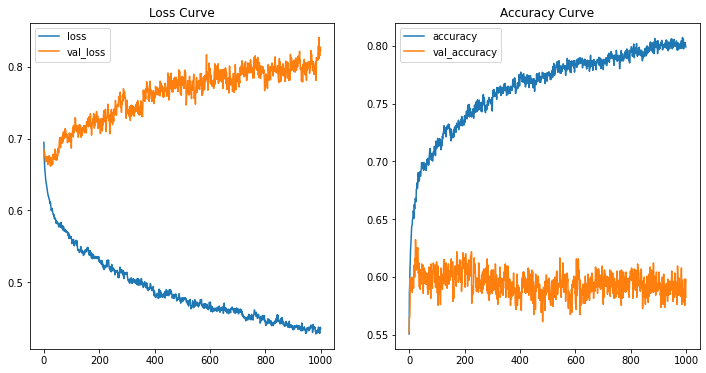

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(1, 22), activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_ds, validation_data=val_ds, epochs=1000)

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].legend()
axs[0].set_title('Loss Curve')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
axs[1].legend()
axs[1].set_title('Accuracy Curve')
plt.show()

Epoch 1/800
51/51 [==============================] - 3s 15ms/step - loss: 0.7111 - accuracy: 0.5320 - val_loss: 0.6841 - val_accuracy: 0.5709
Epoch 2/800
51/51 [==============================] - 0s 6ms/step - loss: 0.6729 - accuracy: 0.5922 - val_loss: 0.6776 - val_accuracy: 0.6025
Epoch 3/800
51/51 [==============================] - 0s 6ms/step - loss: 0.6617 - accuracy: 0.6143 - val_loss: 0.6785 - val_accuracy: 0.5963
Epoch 4/800
51/51 [==============================] - 0s 6ms/step - loss: 0.6479 - accuracy: 0.6300 - val_loss: 0.6786 - val_accuracy: 0.5954
Epoch 5/800
51/51 [==============================] - 0s 6ms/step - loss: 0.6445 - accuracy: 0.6346 - val_loss: 0.6759 - val_accuracy: 0.5841
Epoch 6/800
51/51 [==============================] - 0s 7ms/step - loss: 0.6440 - accuracy: 0.6392 - val_loss: 0.6701 - val_accuracy: 0.6077
Epoch 7/800
51/51 [==============================] - 0s 6ms/step - loss: 0.6386 - accuracy: 0.6454 - val_loss: 0.6760 - val_accuracy: 0.6068
Epoch 8/800


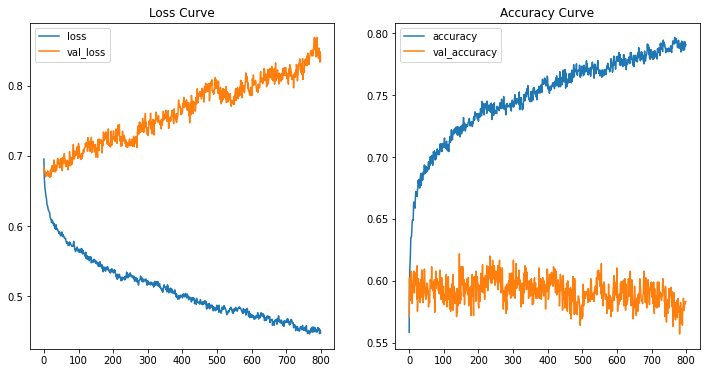

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(1, 22), activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_ds, validation_data=val_ds, epochs=800)

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].legend()
axs[0].set_title('Loss Curve')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
axs[1].legend()
axs[1].set_title('Accuracy Curve')
plt.show()

### 제출용 Data 만들기

In [ ]:
answer = pd.Series([1 if value >= 0.5 else 0 for value in model.predict(test_x)], name='target')


In [ ]:
submission = pd.concat([test['id'], answer], axis=1)
submission.to_csv('submission.csv', index=False)

In [ ]:
submission

,id,target
0,0,[0.4051147]
1,2,[0.5386247]
2,3,[0.210464]
3,9,[0.18545985]
4,11,[0.26161954]
...,...,...
3258,10861,[0.80544835]
3259,10865,[0.9691775]
3260,10868,[0.053576767]
3261,10874,[0.28784662]


In [ ]:
model_epoch = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(1, 22), activation='tanh'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])


history = model.fit(train_ds, validation_data=val_ds, epochs=10)

_, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val_loss')
axs[0].legend()
axs[0].set_title('Loss Curve')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val_accuracy')
axs[1].legend()
axs[1].set_title('Accuracy Curve')
plt.show()